Build a simple Sequential Model from an LSTM. 

* Given a sequence of n-grams, the classifier predicts the following token as a class. 
* The input of the neural network is an array of sequences of tokens for the design matrix and the output a vector of labels that corresponds to the target token.


### Motivation

In the case of the n-gram language model, we used the probability of each n-gram in the input sentence to calculate the perplexity. Our current model does not rely on n-grams, but on probabilities of sequences of tokens to be followed by a subsequent token. We need to adapt the perplexity formula for n-grams language models to sequence-based language models.

If we consider the sentence of N tokens:

$$w_{1},\cdots, w_N$$

Then we can calculate the probability of that sentence as the product of probabilities of all the padded subsequences. Let’s take an example of a 3-token sentence.

$$ P(w_1,w_2, w_3) =  P(w_3 | w_1, w_2) \times p(w_2 | w_1 ,0)  \times p(w_1 | 0 ,0) $$

In general, for a sentence of N tokens and a sequence length of length S,

$$ P(w_1,\cdots, w_N) = \prod_{k = 1}^{ \max{(N,S)}} P(w_k | \text{padded}_S(w_{1}, \cdots, w_{k-1})    )  $$

where $ P(w_{k} | \text{padded}_S(w_{1}, \cdots, w_{k-1}) $ is precisely the probability given by the classification model.

We can therefore compute the perplexity of a sentence of length N with

$$PP(w_{1},\cdots, w_N) = \exp [ - \frac{1}{N} {\sum_{i = 1}^{ \max{(N,S)} } \log { P(w_{k} | \text{padded}_S(w_{1}, \cdots, w_{k-1}) } } ) ]$$

### Workflow

#### Preparing the data

1. Load the dataset that was prepared in task 1.
2. The original dataset is too large and needs to be reduced. To reduce it, you can, for instance,
   + filter out items that have too many or too little tokens,
   + select items of a certain type: post, comments, or titles, or
   + or sub sample items randomly.
3. Build the vocabulary as the set of all unique tokens to construct the list of token indexes.
  + Filtering on token frequency is one way to reduce the overall size of the vocabulary.
4. Set a fixed sequence length and build sequences of token indexes from the corpus. (See for instance keras pad_sequences.)
5. Split the sequences into predictors and labels (`keras.utils.to_categorical`)

#### The model

The data is now ready to be used to fit a neural network.

1. Define a simple sequential model with an embedding layer, LSTM(s), and a dense layer with softmax activation. Feel free to experiment with dropouts, different optimizers. You can use any type of neural net you want; for example, Keras, TensorFlow, PyTorch, and so on.
2. Specify the number of epochs, the batch size, and other fitting parameters.
3. Fit the network.

#### Assessing the results

1. Write a function that generates text.
2. Generate some text and take note of:
  - Token repetitions
  - Missing punctuations
  - Other anomalies
3. Write a function that calculates **perplexity of a sentence** and apply it to a subset of sentences to evaluate the model.
4. Define a validation set; for instance, 1000 titles.
5. Transform that validation set into sequences of tokens using the training vocabulary.
6. Tune the neural net and the parameters of the preprocessing phase to improve the model’s perplexity score.

#### References

Fast.ai 2019

* Lesson 4
  - NLP classification - https://github.com/fastai/course-v3/blob/master/nbs/dl1/lesson3-imdb.ipynb
  - https://youtu.be/qqt3aMPB81c?t=1038
  - What's an Embedding - https://www.youtube.com/watch?v=GK1XhPM3K0g&feature=youtu.be&t=540
    - project something into a higher dimensional space. int(s) -> vector of floats. 
* Lesson 12 (video snippets in the noteook.
  - Preparing Text - https://github.com/fastai/course-v3/blob/master/nbs/dl2/12_text.ipynb
  - AWD LSTM - https://github.com/fastai/course-v3/blob/master/nbs/dl2/12a_awd_lstm.ipynb
  - Read in Wikitext to train LM - https://github.com/fastai/course-v3/blob/master/nbs/dl2/12b_lm_pretrain.ipynb
  - UMLFIT - https://github.com/fastai/course-v3/blob/master/nbs/dl2/12c_ulmfit.ipynb

When to reset or repackage the hidden state?
  - Concept: stateless or stateful RNNs (this was a Keras thing)
  - repackage / detach hidden weight tensors
    - https://discuss.pytorch.org/t/solved-why-we-need-to-detach-variable-which-contains-hidden-representation/1426
    - https://github.com/pytorch/examples/blob/master/word_language_model/main.py#L112
    - deeplearning.ai lecture - https://www.youtube.com/watch?v=esgbmJ6SnSY

Fast.ai 2018

* https://forums.fast.ai/t/wiki-lesson-4/9402 (Intro NLP lesson)
* https://forums.fast.ai/t/wiki-lesson-6/9404 (Follow up NLP lesson)
* https://forums.fast.ai/t/wiki-lesson-7/9405 (Build Char RNN from scratch)
  - repackage / state - https://youtu.be/H3g26EVADgY?t=660
    + part of my confusion from what bptt means comes from this clip. He states that detaching is part of bptt. Not sure the are truly related. 


### RNN Notes

* BPTT - backprop through time.  When you calculate the gradients the hidden activations (hidden state produced by the hidden layer) understand that it's loop over itself from the last input to the first. Therefore the computation graph grows linearly with each forward pass. To prevent vanishing gradients and not have a very large slow computation you need to `detach()` the hidden state from the computational graph. 
* sequence length - how long of a sequence the RNN will process when it processes a mini-batch. This is often the same size as BPTT but it doesn't have to be.  If you want to capture the loss of all inputs from the sequence in the minibatch then BPTT > seq_len 


### Preparing the data

In [2]:
import pandas as pd

In [3]:
TOK_FILE= 'stackexchange_tokenized.csv'
df = pd.read_csv(f'data/{TOK_FILE}')

In [4]:
# Specify the number of epochs, the batch size, and other fitting parameters

seq_len = 50
vocab_size = 4000
embedding_dim = 200
hidden_dim = 40
batch_size = 15
epochs = 25

In [5]:
df.head()


,Unnamed: 0,post_id,parent_id,comment_id,text,category,length,tokenized
0,0,1,NaN,NaN,Eliciting priors from experts,title,29,Eliciting priors from experts
1,1,2,NaN,NaN,What is normality?,title,18,What is normality ?
2,2,3,NaN,NaN,What are some valuable Statistical Analysis op...,title,65,What are some valuable Statistical Analysis op...
3,3,4,NaN,NaN,Assessing the significance of differences in d...,title,58,Assessing the significance of differences in d...
4,4,6,NaN,NaN,The Two Cultures: statistics vs. machine learn...,title,50,The Two Cultures : statistics vs. machine lear...


In [5]:
df.size

6473328

In [64]:
df[df['length'] > 4000].size

11136

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb3fedc1080>]],
      dtype=object)

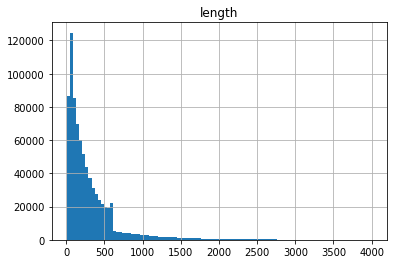

In [17]:
%matplotlib inline

df2 = df[df['length'] < 4000]
df2.hist(column="length", bins=100)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb3fb338908>]],
      dtype=object)

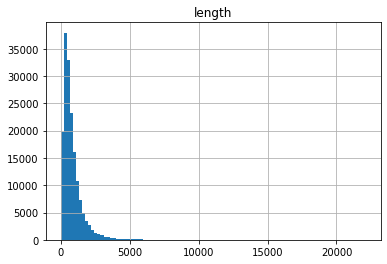

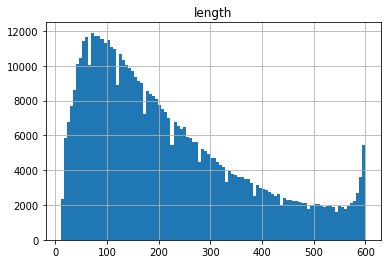

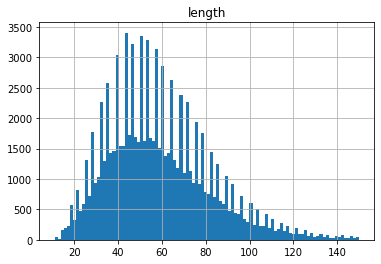

In [21]:
df_post = df[df['category'] == 'post']
df_title = df[df['category'] == 'title']
df_comment = df[df['category'] == 'comment']

df_post.hist(column="length", bins=100)
df_comment.hist(column="length", bins=100)
df_title.hist(column="length", bins=100)

# note that only posts have a long tail that get huge. 
# I would expect phrases to appear differently in long and short text. 


In [ ]:
# reduce the dataset


In [ ]:
# build the vocabularly from the set of unique tokens

#### Fastai v1

Letting Fast.ai do the tokenizing and numericalizing

https://youtu.be/vnOpEwmtFJ8?t=5080

In [6]:
from fastai.text import *

In [9]:
%%time

# TODO: consider a better way to combine values in the dataset. 
# Instead of just using text could you combine text and title? 

# if we use fast.ai we could do this
tokenizer = Tokenizer()
texts  = df['text'].values
tokens = tokenizer.process_all(texts)

#create tokens from a list of lists of tokens.  https://bit.ly/31xOsvf
vocab = Vocab.create(tokens, max_vocab=vocab_size, min_freq=2)


CPU times: user 15.6 s, sys: 1.81 s, total: 17.4 s
Wall time: 53.2 s


In [10]:
ntokens = [ vocab.numericalize(ta) for ta in tokens ] 

In [21]:
%%time

ntok_tensors = [ torch.tensor(tka).type(torch.int64) for tka in ntokens ]




CPU times: user 17.4 s, sys: 383 ms, total: 17.8 s
Wall time: 17.8 s


In [22]:
ntok_tensors[7]

tensor([   5,  371,   45,  794,   79,    5, 1679, 1578,   30,  147,   35,  818,
          44,  286,   40,   26])

In [23]:
ntok_tsr = torch.cat(ntok_tensors) #1D tensor. 


In [ ]:
# pick the right fixed sequence length


In [26]:
# split into training and test.

from sklearn.model_selection import train_test_split


corp_size = ntok_tsr.shape[0]
indxs     = np.arange(corp_size)
train_i, test_i = train_test_split(indxs, test_size=0.4, random_state=42)  
test_i, valid_i = train_test_split(test_i, test_size=0.5, random_state=42)

train_tsr = torch.gather(ntok_tsr, 0, torch.tensor(train_i))
test_tsr  = torch.gather(ntok_tsr, 0, torch.tensor(test_i))
valid_tsr = torch.gather(ntok_tsr, 0, torch.tensor(valid_i))



In [28]:
# split the sequence into predictors and labels



# copied from https://bit.ly/2VyEJBa

#expects a 1D tensor (all training, test, validation data) and a batch size. 
def batchify(data, bsz):
    # Work out how cleanly we can divide the dataset into bsz parts.
    nbatch = data.size(0) // bsz
    # Trim off any extra elements that wouldn't cleanly fit (remainders).
    data = data.narrow(0, 0, nbatch * bsz)
    # Evenly divide the data across the bsz batches.
    data = data.view(bsz, -1).t().contiguous()
    #return data.to(device)
    return data
    
def get_batch(source, i):
    #seq_len = min(args.bptt, len(source) - 1 - i)
    seq_len = len(source) - 1 - i
    data = source[i:i+seq_len]
    #target = source[i+1:i+1+seq_len].view(-1) #TODO: why reshape this? probably easier to run loss function. 
    target = source[i+1:i+1+seq_len]
    return data, target



### Notes:
# example code has bptt as the sequence length
# example code grabs bptt / seq_len rows at a time when processing a batch. Makes sense but feels strange
# Question: does the example code ever reset the hidden weights? I don't think so. 
# - I would have thought this is where bptt would have hppened. 
# - alternatively you should reset at some point in `forward` https://bit.ly/2NNEY76

# Do you want to create a dataloader or not? It could wrap a dataset with "tokens" variable.
# see collate_fn, shuffle and batch_sampler arguments. 
# UPDATE: lots of interesting ideas in fast.ai 
# - create a collate_fn function that pads things - https://youtu.be/vnOpEwmtFJ8?t=6245 (fast.ai)
# - create samplers that orders data for batching by size (or roughly by size)
# - do batchify when you create a dataset. 
# - example dataset - https://youtu.be/vnOpEwmtFJ8?t=5786

In [52]:

# there wasn't a really good reason to write this. You could get away without it.  
class LMDataset(Dataset):
    
    def __init__(self, data, bsz, seq_len):
        """
        Parameters:
        data (Tensor): Rank 1 tensor with all numericalized data in it.     
        """
        self.by_batch = batchify(data, bsz) 
        self.data = data
        self.batch_size = bsz
        self.seq_len = seq_len
        
    def __getitem__(self, idx):
        xi = idx % self.batch_size
        yi = idx // self.batch_size * seq_len
        print(self.by_batch.shape)
        source = self.by_batch[xi:xi+self.seq_len, yi]
        target = self.by_batch[xi+1:xi+self.seq_len+1, yi]
        return source, target
        
    #TODO: do you want to copy the batching function in here? 
    #remove this? 
    def get_batch(self):
        pass


# LEFT OFF HERE.  If you want to create the dataloader you set shuffle to false and just instantiate one. 
# Debugging would have been easier if you numericalized as part of a transform. 

In [53]:
lmd = LMDataset(test_tsr, batch_size, seq_len)

In [54]:
lmd[3]

torch.Size([764706, 15])


(tensor([   5,  143,   15,  466,   29,   12,    0,    5,    0,  100,   11,   28,
           13,   14,  346,   14,  184,  396,   24,   16,   39,  192,    9,    6,
           66,  450,  278,   13,   14,    5,   75,   12,    5,   13,  410,  731,
          120,  128,   13,  383,    5,   68,    0,   97,  966,   17,    5, 3125,
          167, 1024]),
 tensor([ 143,   15,  466,   29,   12,    0,    5,    0,  100,   11,   28,   13,
           14,  346,   14,  184,  396,   24,   16,   39,  192,    9,    6,   66,
          450,  278,   13,   14,    5,   75,   12,    5,   13,  410,  731,  120,
          128,   13,  383,    5,   68,    0,   97,  966,   17,    5, 3125,  167,
         1024,   13]))

### The model

In [44]:
# define the model

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F


In [8]:
%load_ext autoreload
%autoreload 2

from rnn_model import *

In [13]:
### https://pytorch.org/tutorials/beginner/nlp/sequence_models_tutorial.html
### views in pytorch - https://pytorch.org/docs/stable/tensors.html#torch.Tensor.view
### Maybe skip this one - https://gist.github.com/williamFalcon/f27c7b90e34b4ba88ced042d9ef33edd
### https://pytorch.org/docs/master/generated/torch.nn.LSTM.html
### https://github.com/pytorch/examples/tree/master/word_language_model
### https://stackoverflow.com/a/42482819 reshaping tensors with "view"
### https://medium.com/@lankinen/fast-ai-lesson-12-notes-part-2-v3-dd53bec89c0b
### - https://www.youtube.com/watch?v=vnOpEwmtFJ8&feature=emb_title


class Net(nn.Module):
    def __init__(self, seq_len, vocab_size, embedding_dim, hidden_dim): #TODO: DO I NEED THE seq_len here? Doubt it. 
        
        super(Net, self).__init__()
        self.vocab_size = vocab_size
        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.lstm =  nn.LSTM(embedding_dim, hidden_dim)
        self.dense = nn.Linear(hidden_dim, vocab_size)
        
        self.init_weights()
        
    def forward(self, x, hidden):
        
        # decide how/when to reset and share hidden params? Consider bptt approach. 
        # - when you process inputs...
        # x - review "batchify" and "get_batch" from - https://bit.ly/2VyEJBa so that you understand how they batch data and get labeels, etc.
        # x - in prepping data for language models, do you need to pad anything? 
        # x  I don't believe so. I think 'batchify' combines sentences together. See `data.view(bsz, -1).t().contiguous()`
        # x - figure out how bptt is used in the pytorch LM example code.  Why is it used in get_batch to limit the size? 
        # x - UPDATE: is this is the right question to ask? Perhaps you're really asking when to reset the hidden state 
        #     and how `detach()` works.
        #   - NOTE: in `tokenize` from the pytorch example language model they tokenize and numericalize and return a 1D
        #     tensor of the entire test, training or validation set. 
        # - NOTE: you built your vocab and numericalized with fast.ai. How to combine data together? 
        
        seq_len, batch_size = x.shape   
        x = self.word_embeddings(x)
        x, hidden = self.lstm(x, hidden) # -> (seq_len, batch_size, hidden_size)
        x = self.dense(x)                # -> (seq_len, batch_size, vocab_size)
        x = F.log_softmax(x, dim=2)  #update. Do you want to predict one new thing here instead of a whole bunch?
        #TODO: you could detach and return a new hidden state here. This is fine if you want bptt to always be seq_len.
        return x, hidden 
        
    # From - https://github.com/pytorch/examples/blob/e7870c1fd4706174f52a796521382c9342d4373f/word_language_model/model.py#L56
    # https://discuss.pytorch.org/t/correct-way-to-declare-hidden-and-cell-states-of-lstm/15745
    def init_hidden(self, bsz):
        weight = next(self.parameters())
        return (weight.new_zeros(1, bsz, self.hidden_dim), #right now just one layer is used.
                weight.new_zeros(1, bsz, self.hidden_dim))
   
    def init_weights(self):
        initrange = 0.1
        nn.init.uniform_(self.word_embeddings.weight, -initrange, initrange)
        nn.init.zeros_(self.lstm.weight)
        nn.init.uniform_(self.dense.weight, -initrange, initrange)

In [14]:
net = Net(seq_len, vocab_size, embedding_dim, hidden_dim)

In [49]:
# run `forward` here to make sure that you have the expected dimensions for inputs and outputs.

#fake input
tsr = torch.randint(0,vocab_size, (seq_len, batch_size))
print(tsr.shape)  

out_tensor = net(tsr)
print(out_tensor.shape) 

torch.Size([50, 15])
torch.Size([50, 15, 4000])


In [ ]:


train_data = batchify(train_tsr, batch_size)
test_data  = batchify(test_tsr, batch_size)
valid_data = batchify(valid_tsr, batch_size)

In [1]:
# fit the model

#LEFT OFF HERE -  review sample code from pytorch github and fill this out. 
# https://github.com/pytorch/examples/blob/master/word_language_model/main.py

def train_epoch(model, train_data, seq_len):
    
    model.train()
    hidden = model.init_hidden()
    
    train_rc = train_data.shape[0]
    
    #loop through all the batches in the epoch
    for bi, sob in enumerate(range(0,train_rc, seq_len)):  
        
        data, test = get_batch(train_data, sob)
        
        model.zero_grad()
        
        predicted, hidden = model(data,hidden)
        hidden = hidden.detach() #TODO: if this works, consider just doing it in forward()
        
        #LEFT OFF HERE - you still need to define your loss function. Do you keep everything in the log space when calculating?
        
        #backward - calculate the gradient
        #calculate the loss
        #step - update the weights
    pass

def evaluate_epoch(model):
    #calclate the loss
    pass


def training_loop(model, num_epochs):
    
    for i in range(num_epochs):
        train_epoch(model)
        evaluate_epoch(model)



### Assessing the results

In [ ]:
#Write a function that generates text.

In [ ]:
#Test the function for errors (missing text, punctuation, etc.)

In [ ]:
# Calculate Perplexity

In [ ]:
# Define a validation set; for instance, 1000 titles.

# consider not holding out data when you generate your LM. Okay for unsupervised learning. 
# https://youtu.be/qqt3aMPB81c?t=1266

In [ ]:
# Transform that validation set into sequences of tokens using the training vocabulary.

In [ ]:
# Tune the neural net and the parameters of the preprocessing phase to improve the model’s perplexity score.

#### Testing

In [11]:

emb = nn.Embedding(400, 30)
tsr = torch.LongTensor([[1,2,4,5],[4,3,2,9]])
ts2 = emb(tsr)
ts2.shape

torch.Size([2, 4, 30])

In [16]:
#how to get random tensors that are integers
torch.randint(0,10, (3,4,))

tensor([[5, 6, 9, 7],
        [3, 6, 8, 7],
        [0, 8, 9, 0]])

In [17]:
# copied code from https://github.com/pytorch/examples/tree/master/word_language_model
# testing model dimensions. 
rnn_lm = RNNModel('LSTM', vocab_size, seq_len, embedding_dim, 1, dropout=0)

In [19]:
hidden = rnn_lm.init_hidden(batch_size)
out_tensor, _ = rnn_lm(tsr, hidden)
out_tensor.shape #same output size as my model. **update** they do this intentionally for easy loss calculations. 

torch.Size([750, 4000])

In [31]:
lstm_out = torch.randint(0,vocab_size, (seq_len, batch_size, vocab_size)).float()
#rszd_out = lstm_out.view(seq_len, batch_size, -1) #this is a noop. 
rszd_out = F.softmax(rszd_out, dim=2) #removed log
rszd_out.shape


torch.Size([50, 15, 4000])

In [32]:
#sanity check
summed = torch.sum(rszd_out, dim=2)
summed[0,0]

tensor(1.0000)

In [24]:
torch.randint(0,vocab_size, (2, 3, 4))

tensor([[[2152,  453, 2541, 3116],
         [1831, 3638, 2561, 1046],
         [1450, 2765, 3805, 1294]],

        [[3281, 2037,  266, 3607],
         [3907, 2355, 3675, 1584],
         [3511, 2891, 3937, 2514]]])

##### testing batchify and get_batch

In [29]:
tsr  = torch.LongTensor([1,2,4,5,4,3,2,9, 3, 8, 7, 6])
tsr2 = torch.arange(50)

In [30]:
t2 = batchify(tsr, 4)

In [31]:
t2

tensor([[1, 5, 2, 8],
        [2, 4, 9, 7],
        [4, 3, 3, 6]])

In [52]:
tsr2

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
        36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49])

In [53]:
t3 = batchify(tsr2, 4)

In [54]:
t2[1] #didn't realize this style of indexing worked.

tensor([2, 4, 9, 7])

In [55]:
get_batch(t2, 1)

(tensor([[2, 4, 9, 7]]), tensor([[4, 3, 3, 6]]))

In [56]:
len(t3)

12

In [57]:
get_batch(t3,1)

(tensor([[ 1, 13, 25, 37],
         [ 2, 14, 26, 38],
         [ 3, 15, 27, 39],
         [ 4, 16, 28, 40],
         [ 5, 17, 29, 41],
         [ 6, 18, 30, 42],
         [ 7, 19, 31, 43],
         [ 8, 20, 32, 44],
         [ 9, 21, 33, 45],
         [10, 22, 34, 46]]), tensor([[ 2, 14, 26, 38],
         [ 3, 15, 27, 39],
         [ 4, 16, 28, 40],
         [ 5, 17, 29, 41],
         [ 6, 18, 30, 42],
         [ 7, 19, 31, 43],
         [ 8, 20, 32, 44],
         [ 9, 21, 33, 45],
         [10, 22, 34, 46],
         [11, 23, 35, 47]]))